In [ ]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import LeakyReLU

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

ValueError: Name tf.RaggedTensorSpec has already been registered for class tensorflow.python.ops.ragged.ragged_tensor.RaggedTensorSpec.

In [10]:
X = np.load('x_letters.npy')
y = np.load('y_letters.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

X.shape, y.shape

NameError: name 'np' is not defined

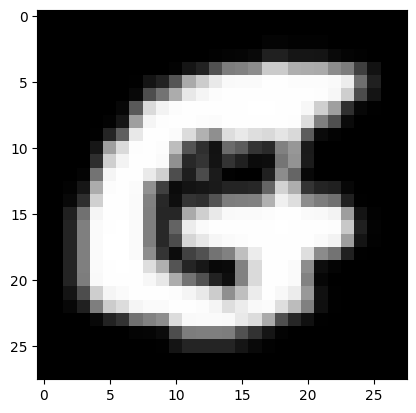

In [ ]:
plt.imshow(X[0], cmap = 'gray')

### Regular GAN

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
       #sample random points in the latent space
       batch_size = ops.shape(real_images)[0]
       random_latent_vectors = keras.random.normal(
           shape = (batch_size, self.latent_dim)
       )

       #create images out of random vectors
       generated_images = self.generator(random_latent_vectors)

       #combine with real images
       combined_images = ops.concatenate([generated_images, real_images], axis = 0)

       labels = ops.concatenate(
           [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis = 0
       )

       # add noise so the generator has a chance
       labels += 0.05*tf.random.uniform(tf.shape(labels))

       #train the discriminator
       with tf.GradientTape() as tape:
          predictions = self.discriminator(combined_images)
          d_loss = self.loss_fn(labels, predictions)
       grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
       self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

       #sample random points in latent space
       random_latent_vectors = keras.random.normal(
           shape = (batch_size, self.latent_dim)
       )

       #misleading labels saying "all real"
       misleading_labels = ops.zeros((batch_size, 1))

       #train generator (don't touch the weights of the discriminator)
       with tf.GradientTape() as tape:
          predictions = self.discriminator(self.generator(random_latent_vectors))
          g_loss = self.loss_fn(misleading_labels, predictions)
       grads = tape.gradient(g_loss, self.generator.trainable_weights)
       self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

       #update metrics
       self.d_loss_metric.update_state(d_loss)
       self.g_loss_metric.update_state(g_loss)
       return {
           "d_loss" : self.d_loss_metric.result(),
           "g_loss" : self.g_loss_metric.result(),
       }


In [ ]:
latent_dim = 32

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(256, activation="tanh"),
        layers.Dense(512, activation="tanh"),
        layers.Dense(28*28, activation="sigmoid"),
        layers.Reshape((28, 28)),
    ],
    name= "generator",
)

discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(150, activation="leaky_relu"),
        layers.Dense(100, activation="leaky_relu"),
        layers.Dense(1, activation="sigmoid"),
    ],
    name= "discriminator",
)

epochs = 20

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(X_train, epochs=epochs)

Epoch 1/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.6243 - g_loss: 1.6709
Epoch 2/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.6476 - g_loss: 1.5997
Epoch 3/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.6399 - g_loss: 1.4921
Epoch 4/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.5843 - g_loss: 1.4385
Epoch 5/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.5456 - g_loss: 1.3802
Epoch 6/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.5452 - g_loss: 1.3974
Epoch 7/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.5516 - g_loss: 1.3650
Epoch 8/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.5547 - g_loss: 1.3329
Epoch 9/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.5458 - g_loss: 1.3189
Epoch 10/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.5457 - g_loss: 1.3487
Epoch 11/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.5367 - g_loss: 1.3716
Epoch 12/20
1776/1776 ━━━━━━━━

In [7]:
def plot_images(n_images, generator, latent_dim):
    random_latent_vectors = keras.random.normal(
            shape=(n_images, latent_dim), seed = keras.random.SeedGenerator(1322)
        )

    images = generator(random_latent_vectors)

    plt.figure(figsize=(n_images * 1.5, 4.5)) # gives space between letters
    for image_index in range(n_images):
        plt.subplot(1, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
    plt.show()

In [8]:
plot_images(10, generator, latent_dim)

NameError: name 'generator' is not defined

### Changing to Conditional GAN

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data): # <-- instead of random points, you now package labels in too
       real_images, real_labels = data
       
       batch_size = ops.shape(real_images)[0]
       random_latent_vectors = keras.random.normal(
           shape = (batch_size, self.latent_dim)
       )

       generated_images = self.generator([random_latent_vectors, real_labels]) # <-- now include labels

       #combine with real images
       combined_images = ops.concatenate([generated_images, real_images], axis = 0)
       combined_labels = ops.concatenate([real_labels, real_labels], axis = 0) # <-- now include labels

       labels = ops.concatenate(
           [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis = 0
       )

       # add noise so the generator has a chance
       labels += 0.05*tf.random.uniform(tf.shape(labels))

       #train the discriminator
       with tf.GradientTape() as tape:
          predictions = self.discriminator([combined_images, combined_labels]) # <-- now include labels
          d_loss = self.loss_fn(labels, predictions)
       grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
       self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

       random_latent_vectors = keras.random.normal(
           shape = (batch_size, self.latent_dim)
       )

       #misleading labels saying "all real"
       misleading_labels = ops.zeros((batch_size, 1))

       #train generator (don't touch the weights of the discriminator)
       with tf.GradientTape() as tape:
          generated_images = self.generator([random_latent_vectors, real_labels]) # <-- now include labels
          predictions = self.discriminator([generated_images, real_labels]) # <-- now include labels
          g_loss = self.loss_fn(misleading_labels, predictions)
       grads = tape.gradient(g_loss, self.generator.trainable_weights)
       self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

       #update metrics
       self.d_loss_metric.update_state(d_loss)
       self.g_loss_metric.update_state(g_loss)
       return {
           "d_loss" : self.d_loss_metric.result(),
           "g_loss" : self.g_loss_metric.result(),
       }

In [ ]:
num_classes = len(np.unique(y_train))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
label_input = keras.Input(shape=(num_classes,))
noise_input = keras.Input(shape=(latent_dim,))
image_input = keras.Input(shape=(28, 28))

latent_dim = 32

# it's not sequential with image and label inputs, so now the structure has to change for both models

g = layers.Concatenate()([noise_input, label_input])
g = layers.Dense(256, activation="tanh", kernel_initializer="he_normal")(g)
g = layers.Dense(784, activation="tanh", kernel_initializer="he_normal")(g)
g = layers.Dense(28*28, activation = "sigmoid")(g)
output = layers.Reshape((28, 28))(g)
generator = keras.Model([noise_input, label_input], output, name="generator")

d = layers.Flatten()(image_input)
d = layers.Concatenate()([d, label_input])
d = layers.Dense(150, kernel_initializer="he_normal")(d)
d = LeakyReLU(0.2)(d)
d = layers.Dense(100, kernel_initializer="he_normal")(d)
d = LeakyReLU(0.2)(d)
output = layers.Dense(1, activation="sigmoid")(d)
discriminator = keras.Model([image_input, label_input], output, name="discriminator")

epochs = 40

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# keras looks at top-level inputs, not for gen/disc, so you have to pack it as one input and then unpack it later in the train step
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat)).batch(64) 
gan.fit(train_dataset, epochs = epochs)

Epoch 1/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6309 - g_loss: 1.2138
Epoch 2/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.5712 - g_loss: 1.1572
Epoch 3/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6210 - g_loss: 1.0360
Epoch 4/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - d_loss: 0.6183 - g_loss: 1.0066
Epoch 5/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6210 - g_loss: 1.0141
Epoch 6/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - d_loss: 0.6257 - g_loss: 1.0027
Epoch 7/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - d_loss: 0.6250 - g_loss: 0.9971
Epoch 8/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6264 - g_loss: 0.9943
Epoch 9/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - d_loss: 0.6302 - g_loss: 0.9831
Epoch 10/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6345 - g_loss: 0.9695
Epoch 11/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6408 - g_loss: 0.9554
Epoch 12/40
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Trial 1 (class code with 10 epochs) - generator loss explodes after 5+ epochs, discriminator loss decreases sharply

Trial 2 (increase generator neuron capacity to capture more complex patterns) - generator loss increases after 5ish epochs, but discriminator loss stabilizes at ~0.6

Trial 3 (decrease learning rate for generator to 0.0005 and generator to 0.001) - discriminator loss decreases, generator loss slowly increases

Trial 4 (swap generator loss to tanh over relu) - discriminator loss stabilizes to 0.53, generator loss decreases for a while to around 1.3 but then starts icnreasing

Trial 5 (swap discriminator loss to leaky_relu over relu, bump up epochs to 30) - discriminator loss stabilizes to 0.6ish, generator loss decreases and cuts off at 1.006

Trial 6 (bump up epochs to 40) - discriminator loss ends at 0.63, generator loss decreases to 0.966

Trial 7 (bump up epochs to 60) - discriminator loss ends at 0.64, generator loss decreases to 0.919

Trial 8 (added batch normalization in generator) - same performance as trial 6

Trial 9 (remove batch norms, add third layer in generator w/ 784 neurons) - 0.68 and 0.80 halfway, but started changing to 0.66 and 0.86 by epoch 60

Trial 10 (halve epochs, remove 3rd layer and increase neurons in other 2) - 0.66 and 0.86

Trial 11 (decrease neurons in 1st, keep 2nd the same) - 0.66, 0.84. but the letters are the clearest yet

In [ ]:
def plot_images(string, generator, latent_dim, num_classes):
    n = len(string)
    
    seed_gen = keras.random.SeedGenerator(1322)
    random_latent_vectors = keras.random.normal(shape=(n, latent_dim), seed=seed_gen)

    # for emnist, it's a = 1 to z = 26, so we need to convert chars to indices
    label_indices = np.array([ord(c.lower()) - ord('a') for c in string])
    labels = tf.keras.utils.to_categorical(label_indices, num_classes=num_classes)

    # convert both to tensors
    random_latent_vectors = tf.convert_to_tensor(random_latent_vectors, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)

    images = generator([random_latent_vectors, labels])

    plt.figure(figsize=(n * 1.5, 4.5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.axis("off")
    plt.show()


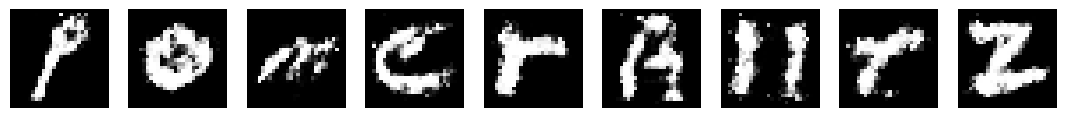

In [ ]:
plot_images("pomerantz", generator, latent_dim, num_classes)

Class sampling w different latent vectors

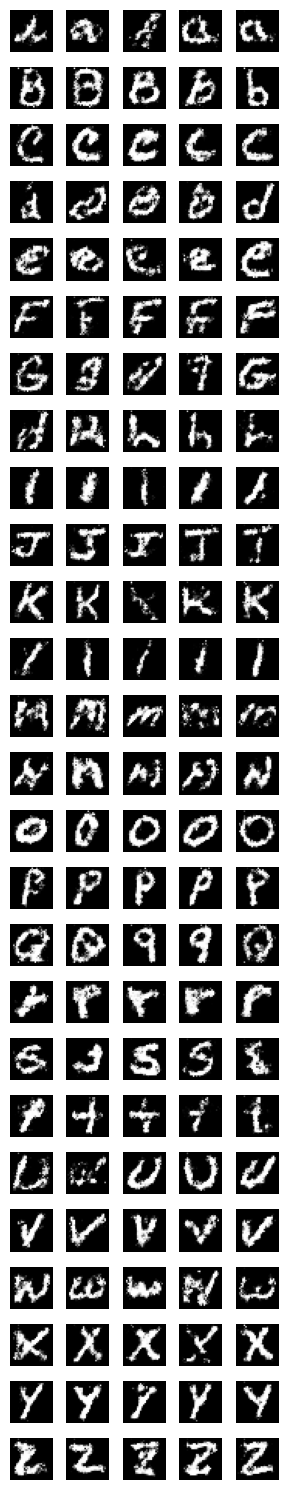

In [ ]:
seed_gen = keras.random.SeedGenerator(1322)
random_latent_vectors = keras.random.normal(shape=(26 * 5, latent_dim), seed=seed_gen)

string = "abcdefghijklmnopqrstuvwxyz"

label_indices = np.array([ord(c.lower()) - ord('a') for c in string])
labels = np.repeat(label_indices, 5) # repeat each label 5 times
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

random_latent_vectors = tf.convert_to_tensor(random_latent_vectors, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

images = generator([random_latent_vectors, labels])

plt.figure(figsize=(2 * 1.5, 15))
for row, char in enumerate(string):
    for col in range(5):
        idx = row * 5 + col
        plt.subplot(26, 5, idx + 1)
        plt.imshow(images[idx], cmap="gray")
        plt.axis("off")
        if col == 0:
            plt.ylabel(char.upper(), fontsize=10, rotation=0, labelpad=12, va="center")
plt.tight_layout()
plt.show()

Check which classes it kinda sucks at generating

In [ ]:
from keras import layers, models

num_classes = y_train_cat.shape[1]

classifier_input = layers.Input(shape=(28,28))
x = layers.Reshape((28,28,1))(classifier_input)
x = layers.Conv2D(32, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
classifier_output = layers.Dense(num_classes, activation='softmax')(x)

classifier = models.Model(classifier_input, classifier_output)
classifier.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)
classifier.fit(X_train, y_train_cat, epochs=5, batch_size=64, validation_split=0.1)


Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7888 - loss: 0.6879 - val_accuracy: 0.8724 - val_loss: 0.4144
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8951 - loss: 0.3262 - val_accuracy: 0.9008 - val_loss: 0.3208
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9164 - loss: 0.2540 - val_accuracy: 0.9053 - val_loss: 0.3101
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9268 - loss: 0.2136 - val_accuracy: 0.9157 - val_loss: 0.2765
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9362 - loss: 0.1826 - val_accuracy: 0.9156 - val_loss: 0.2708


In [ ]:
n_samples = 100  # per class
latent_dim = 32

generated_images = []
true_labels = []

for label in range(num_classes):
    labels_onehot = np.tile(np.eye(num_classes)[label], (n_samples, 1))
    random_latent_vectors = np.random.normal(size=(n_samples, latent_dim))
    imgs = gan.generator.predict([random_latent_vectors, labels_onehot])
    generated_images.append(imgs)
    true_labels.extend([label]*n_samples)

generated_images = np.concatenate(generated_images, axis=0)
true_labels = np.array(true_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


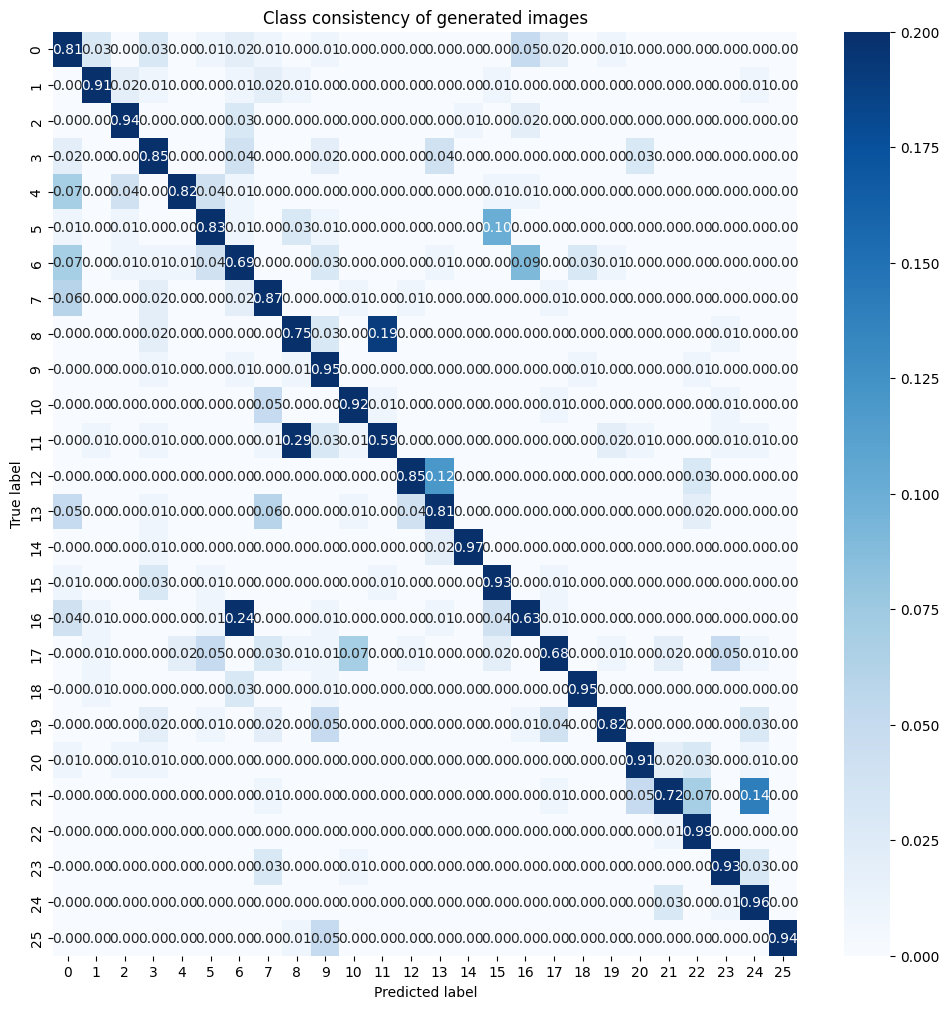

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred_probs = classifier.predict(generated_images)
pred_labels = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 12))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", vmax=0.2)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Class consistency of generated images")
plt.show()